In [1]:
import chainer
from chainer import Link, Chain, ChainList, Variable, optimizers, iterators
import chainer.functions as F
import chainer.links as L
from chainer import cuda
from chainer import initializers
from chainer import serializers

import os
import time, datetime
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import coordinate
import data
from model import oplus, Generator
import xp_settings as settings
settings.set_gpu(0)
xp = settings.xp


In [2]:
def plot_path(cart_path,target,xlim=[-5,5],ylim=[-5,5]):
    fig = plt.figure()
    path = cart_path
    target = target
    if(settings.gpu_index >= 0):
        path = xp.asnumpy(path)
        target = xp.asnumpy(target)
    plt.scatter(target[:,0],target[:,1],c="red",s=80,marker="o")
    for i in range(1,len(path)):
        plt.quiver(path[i-1,0],path[i-1,1]
                   , path[i,0]-path[i-1,0],path[i,1]-path[i-1,1]
                   , scale_units='xy', angles='xy', scale=1,color="blue")
    num_step = len(target)
    #plt.scatter(t[num_step-1,0],t[num_step-1,1],c="yellow",s=500,marker="*")
    plt.xlabel("x[m]")
    plt.ylabel("y[m]")
    plt.axis('scaled')
    plt.xlim(xlim[0],xlim[1])
    plt.ylim(ylim[0],ylim[1])
    plt.grid()
    plt.show()
    return fig

In [3]:
print('Sample 1 : check Oplus')
sample_x1 = Variable(xp.array([1, 1, 1], dtype = 'float32'))
sample_x2 = Variable(xp.array([1, 2, 0], dtype = 'float32'))
print(sample_x1.shape)
sample_z = oplus(sample_x1,sample_x2)
print(sample_z)
sample_z = sample_z * xp.array([1., 1., 0], dtype='float32')
sample_zt = F.transpose(sample_z)
print(sample_zt)
sample_e = F.matmul(sample_z, sample_zt)
print(sample_e)
print(sample_e.shape)
sample_e.backward()

Sample 1 : check Oplus
(3,)
variable([-0.14263964  2.9220755   1.0000002 ])
variable([-0.14263964  2.9220755   0.        ])
variable(8.558871)
()


Sample 2 : plot Oplus
variable([1.8660254 0.5       1.0471976])
variable([2.3660254 1.3660254 1.5707963])
variable([2.3660254 2.3660254 2.094395 ])
[[1.        0.        0.5235988]
 [1.8660254 0.5       1.0471976]
 [2.3660254 1.3660254 1.5707963]
 [2.3660254 2.3660254 2.094395 ]]


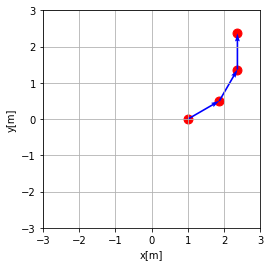

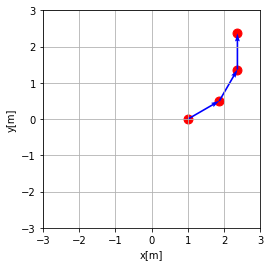

In [4]:
print('Sample 2 : plot Oplus')
sample_x1 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x2 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x3 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x4 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_z1 = oplus(sample_x1,sample_x2)
print(sample_z1)
sample_z2 = oplus(sample_z1,sample_x3)
print(sample_z2)
sample_z3 = oplus(sample_z2,sample_x4)
print(sample_z3)
sample_z = sample_z3 * xp.array([1., 1., 0], dtype='float32')
sample_pathes = xp.array(xp.vstack((sample_x1.data,sample_z1.data,sample_z2.data,sample_z3.data)),dtype='float32')
print(sample_pathes)
plot_path(sample_pathes,sample_pathes,[-3,3],[-3,3])

In [5]:
# dataset
DATA_SIZE = 1000
DATA_NUM_WAYPOINTS = 10
DATA_NUM_STEP = DATA_NUM_WAYPOINTS
DATA_HZ = 10
DATA_MAX_TRANS_VEL = 0.3 # [m/s]
DATA_MAX_ROTATE_VEL = 2*xp.pi # [rad/s]
DATA_M_PER_STEP = DATA_MAX_TRANS_VEL / DATA_HZ # [m/step]
DATA_RAD_PER_STEP = DATA_MAX_ROTATE_VEL / DATA_HZ # [rad/step]

print('DATA_SIZE          :',DATA_SIZE)
print('DATA_NUM_WAYPOINTS :',DATA_NUM_WAYPOINTS)
print('DATA_NUM_STEP      :',DATA_NUM_STEP)
print('DATA_HZ            :',DATA_HZ) 
print('DATA_MAX_TRANS_VEL :',DATA_MAX_TRANS_VEL)
print('DATA_MAX_ROTATE_VEL:',DATA_MAX_ROTATE_VEL)
print('DATA_M_PER_STEP    :',DATA_M_PER_STEP)
print('DATA_RAD_PER_STEP  :',DATA_RAD_PER_STEP)

X_train = []

for i in range(DATA_SIZE):
    rand_rad = xp.random.rand()*(2*DATA_RAD_PER_STEP)-DATA_RAD_PER_STEP # -36 ~ 36 m/step
    d = data.generate_arc_path(DATA_NUM_STEP,rand_rad,DATA_M_PER_STEP)
    d_rotate = data.rotate_path(d,rand_rad/2)
    #d_xy_fl = xp.ravel(d_xy[0:DATA_WAYPOINTS])
    X_train.append(d_rotate)
'''
# old version
for i in range(DATA_SIZE):
    l = int(DATA_NUM_WAYPOINTS*DATA_M_PER_STEP)+1
    rand_rad = xp.random.rand()*(2*DATA_RAD_PER_STEP)-DATA_RAD_PER_STEP # -36 ~ 36 m/step
    d = data.make_arc_path_2(l,rand_rad,s=DATA_M_PER_STEP)
    d_es,_ = data.old_get_evenly_spaced_points(d,DATA_M_PER_STEP)
    d_xy = d_es[0:DATA_NUM_WAYPOINTS]
    X_train.append(d_xy)
'''
print(len(X_train))
print(X_train[0].shape)

DATA_SIZE          : 1000
DATA_NUM_WAYPOINTS : 10
DATA_NUM_STEP      : 10
DATA_HZ            : 10
DATA_MAX_TRANS_VEL : 0.3
DATA_MAX_ROTATE_VEL: 6.283185307179586
DATA_M_PER_STEP    : 0.03
DATA_RAD_PER_STEP  : 0.6283185307179586
1000
(10, 3)


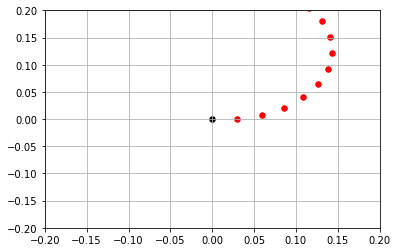

 -- x_train -- 
[[ 2.99312450e-02 -1.18514721e-07 -1.21887737e+00]
 [ 5.90425534e-02  6.95769379e-03 -9.84267367e-01]
 [ 8.57389210e-02  2.04922195e-02 -7.49657367e-01]
 [ 1.08557658e-01  3.98619039e-02 -5.15047367e-01]
 [ 1.26248529e-01  6.40054849e-02 -2.80437367e-01]
 [ 1.37842254e-01  9.16001396e-02 -4.58273672e-02]
 [ 1.42703615e-01  1.21133961e-01  1.88782633e-01]
 [ 1.40566258e-01  1.50988795e-01  4.23392633e-01]
 [ 1.31547289e-01  1.79528901e-01  6.58002633e-01]
 [ 1.16140856e-01  2.05190570e-01  8.92612633e-01]]


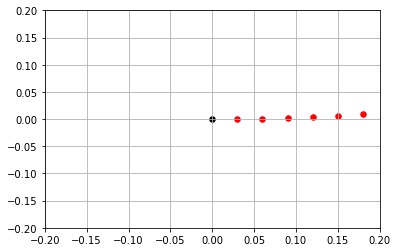

 -- x_train -- 
[[ 2.99994839e-02 -2.88941755e-08 -1.54031536e+00]
 [ 5.99927751e-02  6.09489781e-04 -1.51999536e+00]
 [ 8.99674899e-02  1.82830436e-03 -1.49967536e+00]
 [ 1.19911252e-01  3.65591161e-03 -1.47935536e+00]
 [ 1.49811698e-01  6.09155694e-03 -1.45903536e+00]
 [ 1.79656482e-01  9.13423469e-03 -1.43871536e+00]
 [ 2.09433282e-01  1.27826886e-02 -1.41839536e+00]
 [ 2.39129803e-01  1.70354122e-02 -1.39807536e+00]
 [ 2.68733784e-01  2.18906497e-02 -1.37775536e+00]
 [ 2.98233002e-01  2.73463963e-02 -1.35743536e+00]]


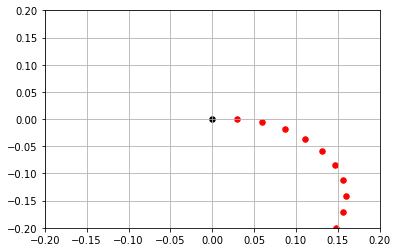

 -- x_train -- 
[[ 2.99460271e-02  1.62574195e-08 -1.88257187e+00]
 [ 5.92475246e-02 -6.17952977e-03 -2.09042187e+00]
 [ 8.66431708e-02 -1.82726314e-02 -2.29827187e+00]
 [ 1.10953684e-01 -3.57587252e-02 -2.50612187e+00]
 [ 1.31132587e-01 -5.78850992e-02 -2.71397187e+00]
 [ 1.46311251e-01 -8.36992946e-02 -2.92182187e+00]
 [ 1.55836292e-01 -1.12090105e-01 -3.12967187e+00]
 [ 1.59297691e-01 -1.41835412e-01 -3.33752187e+00]
 [ 1.56546448e-01 -1.71654788e-01 -3.54537187e+00]
 [ 1.47700994e-01 -2.00264620e-01 -3.75322187e+00]]


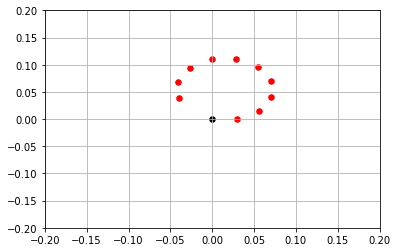

 -- x_train -- 
[[ 2.96555711e-02 -5.89848686e-08 -7.82049338e-01]
 [ 5.53049306e-02  1.48849420e-02 -2.56219338e-01]
 [ 7.00180134e-02  4.06333029e-02  2.69610662e-01]
 [ 6.98195691e-02  7.02882101e-02  7.95440662e-01]
 [ 5.47632145e-02  9.58373604e-02  1.32127066e+00]
 [ 2.89169465e-02  1.10377764e-01  1.84710066e+00]
 [-7.35967936e-04  1.09980825e-01  2.37293066e+00]
 [-2.61837643e-02  9.47537914e-02  2.89876066e+00]
 [-4.05508367e-02  6.88107745e-02  3.42459066e+00]
 [-3.99554216e-02  3.91611813e-02  3.95042066e+00]]


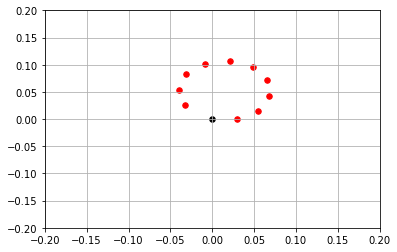

 -- x_train -- 
[[ 2.96213893e-02 -2.63894801e-08 -7.43695436e-01]
 [ 5.48526634e-02  1.55180120e-02 -1.92295436e-01]
 [ 6.82148651e-02  4.19543180e-02  3.59104564e-01]
 [ 6.57472219e-02  7.14727435e-02  9.10504564e-01]
 [ 4.81811833e-02  9.53235504e-02  1.46190456e+00]
 [ 2.07236067e-02  1.06436974e-01  2.01330456e+00]
 [-8.48663870e-03  1.01518817e-01  2.56470456e+00]
 [-3.07911644e-02  8.20268999e-02  3.11610456e+00]
 [-3.95785487e-02  5.37389417e-02  3.66750456e+00]
 [-3.22440691e-02  2.50399501e-02  4.21890456e+00]]


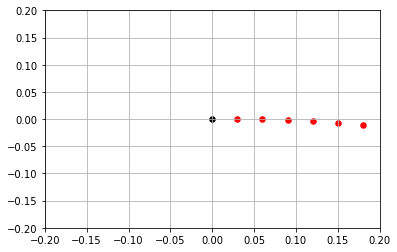

 -- x_train -- 
[[ 2.99993610e-02  8.75445817e-08 -1.60471425e+00]
 [ 5.99910563e-02 -6.78052695e-04 -1.62732425e+00]
 [ 8.99597544e-02 -2.03407406e-03 -1.64993425e+00]
 [ 1.19890136e-01 -4.06728337e-03 -1.67254425e+00]
 [ 1.49766900e-01 -6.77664126e-03 -1.69515425e+00]
 [ 1.79574774e-01 -1.01607627e-02 -1.71776425e+00]
 [ 2.09298522e-01 -1.42179179e-02 -1.74037425e+00]
 [ 2.38922947e-01 -1.89460327e-02 -1.76298425e+00]
 [ 2.68432907e-01 -2.43426902e-02 -1.78559425e+00]
 [ 2.97813317e-01 -3.04051317e-02 -1.80820425e+00]]


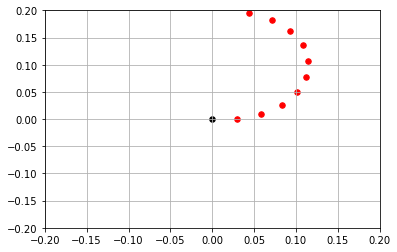

 -- x_train -- 
[[ 2.98879331e-02 -6.47906133e-08 -1.12140916e+00]
 [ 5.84446042e-02  8.82065398e-03 -8.21819159e-01]
 [ 8.31260464e-02  2.56763639e-02 -5.22229159e-01]
 [ 1.01733517e-01  4.90654764e-02 -2.22639159e-01]
 [ 1.12609372e-01  7.69043758e-02  7.69508410e-02]
 [ 1.14784738e-01  1.06713038e-01  3.76540841e-01]
 [ 1.08065822e-01  1.35835962e-01  6.76130841e-01]
 [ 9.30511780e-02  1.61678737e-01  9.75720841e-01]
 [ 7.10783836e-02  1.81939163e-01  1.27531084e+00]
 [ 4.41048819e-02  1.94812342e-01  1.57490084e+00]]


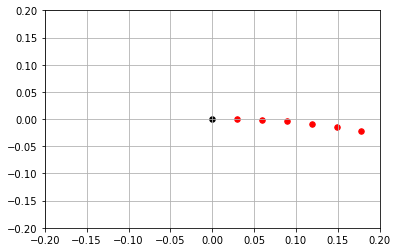

 -- x_train -- 
[[ 2.99970135e-02  9.27750923e-08 -1.64411942e+00]
 [ 5.99582035e-02 -1.46548478e-03 -1.69299942e+00]
 [ 8.98119992e-02 -4.39323171e-03 -1.74187942e+00]
 [ 1.19487087e-01 -8.77615429e-03 -1.79075942e+00]
 [ 1.48912578e-01 -1.46037827e-02 -1.83963942e+00]
 [ 1.78018184e-01 -2.18621960e-02 -1.88851942e+00]
 [ 2.06734375e-01 -3.05340554e-02 -1.93739942e+00]
 [ 2.34992557e-01 -4.05986459e-02 -1.98627942e+00]
 [ 2.62725226e-01 -5.20319253e-02 -2.03515942e+00]
 [ 2.89866136e-01 -6.48065820e-02 -2.08403942e+00]]


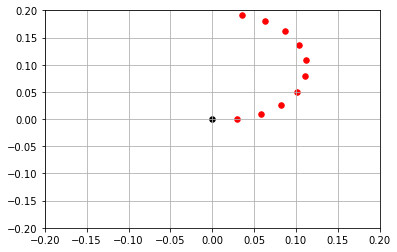

 -- x_train -- 
[[ 2.98813300e-02 -1.10173574e-07 -1.10834264e+00]
 [ 5.83538124e-02  9.06695258e-03 -8.00042640e-01]
 [ 8.27325373e-02  2.63461786e-02 -4.91742640e-01]
 [ 1.00718630e-01  5.02081644e-02 -1.83442640e-01]
 [ 1.10616029e-01  7.84027624e-02  1.24857360e-01]
 [ 1.11491427e-01  1.08271267e-01  4.33157360e-01]
 [ 1.03262275e-01  1.36997125e-01  7.41457360e-01]
 [ 8.67045688e-02  1.61871534e-01  1.04975736e+00]
 [ 6.33796734e-02  1.80548877e-01  1.35805736e+00]
 [ 3.54870899e-02  1.91267910e-01  1.66635736e+00]]


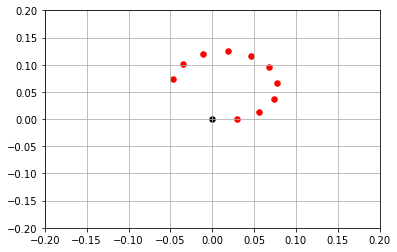

 -- x_train -- 
[[ 2.97192234e-02 -1.35847434e-07 -8.58876756e-01]
 [ 5.61536734e-02  1.35811784e-02 -3.84266756e-01]
 [ 7.34598040e-02  3.77416851e-02  9.03432442e-02]
 [ 7.78119573e-02  6.71405117e-02  5.64953244e-01]
 [ 6.82480551e-02  9.52788132e-02  1.03956324e+00]
 [ 4.68822742e-02  1.15936394e-01  1.51417324e+00]
 [ 1.84376906e-02  1.24546731e-01  1.98878324e+00]
 [-1.07977937e-02  1.19206441e-01  2.46339324e+00]
 [-3.43614421e-02  1.01096038e-01  2.93800324e+00]
 [-4.70443222e-02  7.42189695e-02  3.41261324e+00]]


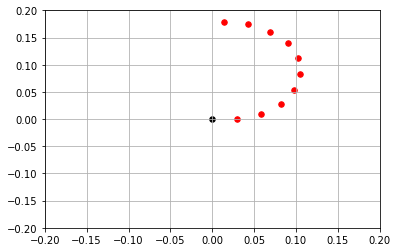

 -- x_train -- 
[[ 2.98622276e-02 -9.20090040e-08 -1.07246325e+00]
 [ 5.80916375e-02  9.73916084e-03 -7.40243246e-01]
 [ 8.16010977e-02  2.81526863e-02 -4.08023246e-01]
 [ 9.78196434e-02  5.32268046e-02 -7.58032457e-02]
 [ 1.04973635e-01  8.22194422e-02  2.56416754e-01]
 [ 1.02280722e-01  1.11960001e-01  5.88636754e-01]
 [ 9.00353962e-02  1.39196092e-01  9.20856754e-01]
 [ 6.95767923e-02  1.60949210e-01  1.25307675e+00]
 [ 4.31422366e-02  1.74840463e-01  1.58529675e+00]
 [ 1.36225785e-02  1.79350720e-01  1.91751675e+00]]


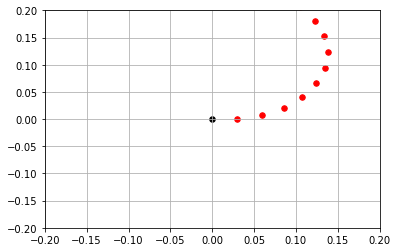

 -- x_train -- 
[[ 2.99256597e-02 -1.45628820e-07 -1.20485146e+00]
 [ 5.89652277e-02  7.22817389e-03 -9.60891460e-01]
 [ 8.53989260e-02  2.12568839e-02 -7.16931460e-01]
 [ 1.07661301e-01  4.12551777e-02 -4.72971460e-01]
 [ 1.24433934e-01  6.60387188e-02 -2.29011460e-01]
 [ 1.34723517e-01  9.41397792e-02  1.49485396e-02]
 [ 1.37920681e-01  1.23894161e-01  2.58908540e-01]
 [ 1.33836086e-01  1.53539754e-01  5.02868540e-01]
 [ 1.22711628e-01  1.81320891e-01  7.46828540e-01]
 [ 1.05206118e-01  2.05592319e-01  9.90788540e-01]]


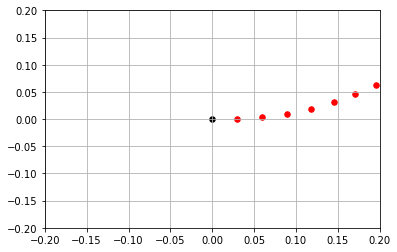

 -- x_train -- 
[[ 2.99862180e-02 -1.31367782e-08 -1.41328089e+00]
 [ 5.98072588e-02  3.14304262e-03 -1.30827089e+00]
 [ 8.91345847e-02  9.39454033e-03 -1.20326089e+00]
 [ 1.17645098e-01  1.86856074e-02 -1.09825089e+00]
 [ 1.45024698e-01  3.09138845e-02 -9.93240889e-01]
 [ 1.70971745e-01  4.59446529e-02 -8.88230889e-01]
 [ 1.95200382e-01  6.36123192e-02 -7.83220889e-01]
 [ 2.17443682e-01  8.37222392e-02 -6.78210889e-01]
 [ 2.37456591e-01  1.06052862e-01 -5.73200889e-01]
 [ 2.55018628e-01  1.30358173e-01 -4.68190889e-01]]


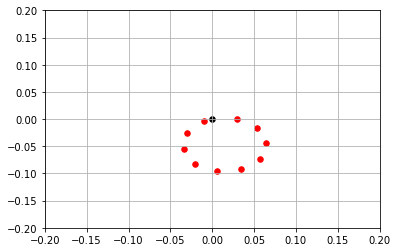

 -- x_train -- 
[[ 2.95427123e-02  2.23867931e-09 -2.48014140e+00]
 [ 5.38209706e-02 -1.68326453e-02 -3.08637140e+00]
 [ 6.41820959e-02 -4.44988509e-02 -3.69260140e+00]
 [ 5.69334224e-02 -7.31384840e-02 -4.29883140e+00]
 [ 3.46583498e-02 -9.25444880e-02 -4.90506140e+00]
 [ 5.29562946e-03 -9.58006368e-02 -5.51129140e+00]
 [-2.06899766e-02 -8.17464513e-02 -6.11752140e+00]
 [-3.40372970e-02 -5.53907899e-02 -6.72375140e+00]
 [-2.99893974e-02 -2.61267103e-02 -7.32998140e+00]
 [-9.98893398e-03 -4.38381921e-03 -7.93621140e+00]]


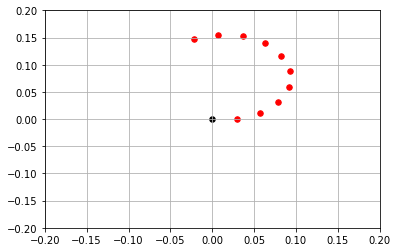

 -- x_train -- 
[[ 2.98178227e-02 -1.45570857e-07 -9.97626445e-01]
 [ 5.74852362e-02  1.11181630e-02 -6.15516445e-01]
 [ 7.90114886e-02  3.17512193e-02 -2.33406445e-01]
 [ 9.12916302e-02  5.89229081e-02  1.48703555e-01]
 [ 9.25543714e-02  8.87139813e-02  5.30813555e-01]
 [ 8.26175745e-02  1.16827370e-01  9.12923555e-01]
 [ 6.29145243e-02  1.39207995e-01  1.29503356e+00]
 [ 3.62871917e-02  1.52627671e-01  1.67714356e+00]
 [ 6.57630715e-03  1.55150743e-01  2.05925356e+00]
 [-2.19326271e-02  1.46413282e-01  2.44136356e+00]]


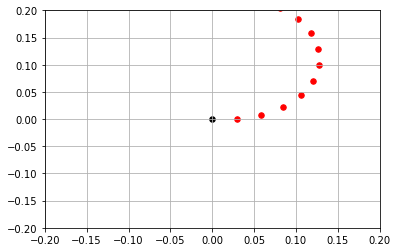

 -- x_train -- 
[[ 2.99119250e-02 -1.40000907e-08 -1.17245586e+00]
 [ 5.87753116e-02  7.85034761e-03 -9.06895859e-01]
 [ 8.45665868e-02  2.30007067e-02 -6.41335859e-01]
 [ 1.05477560e-01  4.43888921e-02 -3.75775859e-01]
 [ 1.20042190e-01  7.05154073e-02 -1.10215859e-01]
 [ 1.27239372e-01  9.95485579e-02  1.55344141e-01]
 [ 1.26564520e-01  1.29452869e-01  4.20904141e-01]
 [ 1.18064948e-01  1.58131791e-01  6.86464141e-01]
 [ 1.02336549e-01  1.83574682e-01  9.52024141e-01]
 [ 8.04820196e-02  2.03997777e-01  1.21758414e+00]]


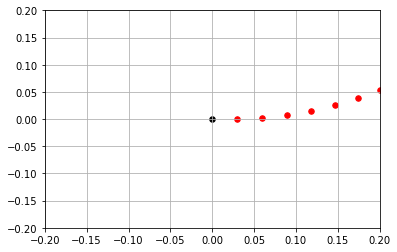

 -- x_train -- 
[[ 2.99906351e-02 -1.03610023e-07 -1.44095287e+00]
 [ 5.98689948e-02  2.59254196e-03 -1.35439287e+00]
 [ 8.94113514e-02  7.75852308e-03 -1.26783287e+00]
 [ 1.18396493e-01  1.54591571e-02 -1.18127287e+00]
 [ 1.46607380e-01  2.56367821e-02 -1.09471287e+00]
 [ 1.73832770e-01  3.82151883e-02 -1.00815287e+00]
 [ 1.99868802e-01  5.31001893e-02 -9.21592872e-01]
 [ 2.24520518e-01  7.01803267e-02 -8.35032872e-01]
 [ 2.47603327e-01  8.93277054e-02 -7.48472872e-01]
 [ 2.68944387e-01  1.10398950e-01 -6.61912872e-01]]


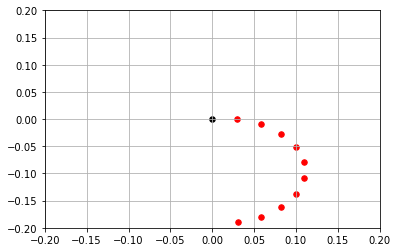

 -- x_train -- 
[[ 2.98770477e-02  5.62216097e-08 -2.04152821e+00]
 [ 5.82949566e-02 -9.22276511e-03 -2.35534821e+00]
 [ 8.24779393e-02 -2.67676028e-02 -2.66916821e+00]
 [ 1.00063865e-01 -5.09207227e-02 -2.98298821e+00]
 [ 1.09334986e-01 -7.93229109e-02 -3.29680821e+00]
 [ 1.09385723e-01 -1.09199916e-01 -3.61062821e+00]
 [ 1.00211121e-01 -1.37633429e-01 -3.92444821e+00]
 [ 8.27073310e-02 -1.61846138e-01 -4.23826821e+00]
 [ 5.85840773e-02 -1.79473010e-01 -4.55208821e+00]
 [ 3.01976568e-02 -1.88792297e-01 -4.86590821e+00]]


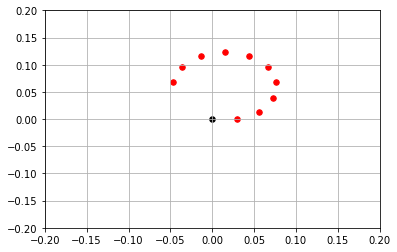

 -- x_train -- 
[[ 2.97102215e-02 -4.56725441e-08 -8.47524790e-01]
 [ 5.60330871e-02  1.37768919e-02 -3.65344790e-01]
 [ 7.29662535e-02  3.81892891e-02  1.16835210e-01]
 [ 7.66484895e-02  6.76704424e-02  5.99015210e-01]
 [ 6.62401430e-02  9.54978315e-02  1.08119521e+00]
 [ 4.41146057e-02  1.15326040e-01  1.56337521e+00]
 [ 1.53171135e-02  1.22633687e-01  2.04555521e+00]
 [-1.35857070e-02  1.15754426e-01  2.52773521e+00]
 [-3.60032113e-02  9.62569197e-02  3.00991521e+00]
 [-4.68235869e-02  6.85871395e-02  3.49209521e+00]]


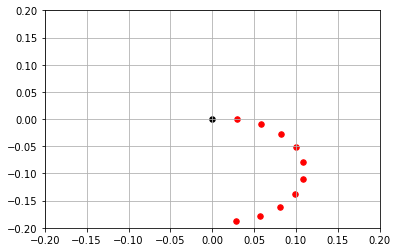

 -- x_train -- 
[[ 2.98753830e-02  9.36276374e-08 -2.04470946e+00]
 [ 5.82721050e-02 -9.28240010e-03 -2.36064946e+00]
 [ 8.23791592e-02 -2.69286021e-02 -2.67658946e+00]
 [ 9.98101753e-02 -5.11917055e-02 -2.99252946e+00]
 [ 1.08839648e-01 -7.96698925e-02 -3.30846946e+00]
 [ 1.08573744e-01 -1.09544092e-01 -3.62440946e+00]
 [ 9.90387867e-02 -1.37857041e-01 -3.94034946e+00]
 [ 8.11786456e-02 -1.61806026e-01 -4.25628946e+00]
 [ 5.67613060e-02 -1.79020323e-01 -4.57222946e+00]
 [ 2.82038534e-02 -1.87795881e-01 -4.88816946e+00]]


In [6]:
# plot data
p = X_train
random.shuffle(p)
if(settings.gpu_index >= 0):
    p = chainer.cuda.to_cpu(X_train)

for num in range(20):
    plt.scatter(0, 0,c="black",edgecolor="black",s=30,marker="o")
    plt.scatter(p[num][:,0], p[num][:,1],c="red",edgecolor="red",s=30,marker="o")
    plt.xlim([-.2,.2])
    plt.ylim([-.2,.2])
    plt.grid()
    plt.show()
    print(' -- x_train -- ')
    print(p[num])

In [7]:
# loss
def error_squares(z_oplus,z_true):
    #print(predict)
    #print(groundtruth)
    w = xp.array([1., 1., 0.],dtype=xp.float32)
    t = z_true * w
    p = z_oplus * w
    error = F.sqrt(F.sum((t-p)*(t-p)))
    return error

def error_limit_rotate_vel(predict,limit):
    w = xp.array([0., 0., 1.],dtype=xp.float32)
    p = predict * w
    vel = F.sum(F.absolute(p))
    if vel.data < limit:
        error = vel * .0
    else:
        error = (vel - limit) / limit
    return error

def error_limit_trans_vel(predict,limit):
    w = xp.array([1., 0., 0.],dtype=xp.float32)
    p = predict * w
    vel = F.sum(F.absolute(p))
    if vel.data <= limit:
        error = vel * .0
    else:
        error = (vel - limit) / limit
    return error

def error_diff_v(y0, y1):
    w = xp.array([0., 0., 1.],dtype=xp.float32)
    v0 = y0 * w
    v1 = y1 * w
    error = F.absolute(F.sum(v1 - v0))
    return error

def error_diff_w(y0, y1):
    w = xp.array([0., 0., 1.],dtype=xp.float32)
    v0 = y0 * w
    v1 = y1 * w
    error = F.absolute(F.sum(v1 - v0))
    return error

def calc_oplus(y):
    dst = []
    z = y[0,0]
    dst.append(z)
    for step in range(1,DATA_NUM_STEP):
        z = oplus(z,y[0,step])
        dst.append(z)
    return dst

def loss_function(y, y_true,disp_loss=0):
    dmesg = ''
    z_true = y_true
    z_oplus = calc_oplus(y)
    # distance
    e_distance = error_squares(z_oplus[0],z_true[0])
    for i in range(1,DATA_NUM_WAYPOINTS):
        e_distance = e_distance + error_squares(z_oplus[i],z_true[i])
    dmesg = dmesg + 'e_distance: ' + str(e_distance) + '\t'
    '''
    # limit v
    e_lim_v = error_limit_trans_vel(y[0,0], DATA_M_PER_STEP)
    for i in range(1,DATA_NUM_STEP):
        e_lim_v = e_lim_v + error_limit_trans_vel(y[0,i], DATA_M_PER_STEP)
    dmesg = dmesg + 'e_distance: ' + str(e_distance) + '\t'
    # limit w
    e_lim_w = error_limit_rotate_vel(y[0,0], DATA_RAD_PER_STEP)
    for i in range(1,DATA_NUM_STEP):
        e_lim_w = e_lim_w + error_limit_rotate_vel(y[0,i] , DATA_RAD_PER_STEP)
    dmesg = dmesg + 'e_distance: ' + str(e_distance) + '\t'
    '''
    
    '''
    e_diff_v = error_diff_v(y[0,0],y[0,1])
    for i in range(2,DATA_NUM_STEP):
        e_diff_v = error_diff_v(y[0,i-1],y[0,i])
    dmesg = dmesg + 'e_dv: ' + str(e_distance) + '\t'
    '''
    e_diff_w = error_diff_v(y[0,0],y[0,1])
    for i in range(2,DATA_NUM_STEP):
        e_diff_w = error_diff_w(y[0,i-1],y[0,i])
    dmesg = dmesg + 'e_dw: ' + str(e_distance) + '\t'
    
    loss = (100 * e_distance)
    #loss = loss + (1 * e_lim_w)
    #loss = loss + (1 * e_lim_v)
    #loss = loss + (1 * e_diff_v)
    loss = loss + (1 * e_diff_w)
    if(disp_loss):
        print(dmesg)
    return loss

In [8]:
# training
def train(model,X,epoch=10):
    if settings.gpu_index >= 0:
        cuda.cupy.cuda.Device(settings.gpu_index).use()
        model.to_gpu(settings.gpu_index)
    opt = optimizers.Adam()
    opt.setup(model)
    ep = 0
    AvgLoss = []
    while ep < epoch:
        random.shuffle(X)
        L = .0
        for itr in range(len(X)):
            x = xp.ravel(X[itr][:,0:2])
            x = Variable(xp.array([x],dtype=xp.float32))
            y = model(x)
            # zero-padding
            pad = Variable(xp.zeros((1,DATA_NUM_WAYPOINTS,1),dtype=xp.float32))
            y_pad = F.concat((y,pad),axis=2)
            y_pad = F.permutate(y_pad, xp.array([0,2,1],'i'), axis=2)
            # loss
            loss = loss_function(y_pad, X[itr][:])
            model.cleargrads()
            loss.backward()
            opt.update()
            # y_grad = chainer.grad( (e,), (y,) )[0]
            # print(y_grad)
            # x_grad = chainer.grad( (e,), (x,) )[0]
            # print(x_grad)
            L = L + loss.data
        ep = ep + 1
        print('Epoch:',ep,', Average loss:',L / len(X))
        AvgLoss.append(L / len(X))
    fig = plt.figure()
    plt.plot(range(len(AvgLoss)),AvgLoss)
    plt.xlabel('Epoch')
    plt.ylabel('Average loss (squares)') #*10, lim_v, lim_w, )')
    plt.text(len(AvgLoss)-1, AvgLoss[-1],str(AvgLoss[-1]),ha='center',va='top' )
    return model, fig

Epoch: 1 , Average loss: 66.97131
Epoch: 2 , Average loss: 35.72958
Epoch: 3 , Average loss: 29.961819
Epoch: 4 , Average loss: 26.929478
Epoch: 5 , Average loss: 24.4991
Epoch: 6 , Average loss: 22.746939
Epoch: 7 , Average loss: 21.110748
Epoch: 8 , Average loss: 20.047453
Epoch: 9 , Average loss: 18.671541
Epoch: 10 , Average loss: 17.872784
Epoch: 11 , Average loss: 16.689644
Epoch: 12 , Average loss: 16.265305
Epoch: 13 , Average loss: 15.351883
Epoch: 14 , Average loss: 14.885757
Epoch: 15 , Average loss: 14.297971
Epoch: 16 , Average loss: 14.158012
Epoch: 17 , Average loss: 13.918568
Epoch: 18 , Average loss: 13.646574
Epoch: 19 , Average loss: 13.511459
Epoch: 20 , Average loss: 13.200546
Epoch: 21 , Average loss: 13.143515
Epoch: 22 , Average loss: 12.833399
Epoch: 23 , Average loss: 12.670028
Epoch: 24 , Average loss: 12.619784
Epoch: 25 , Average loss: 12.4048815
Epoch: 26 , Average loss: 12.268879
Epoch: 27 , Average loss: 11.996741
Epoch: 28 , Average loss: 11.832453
Epoc

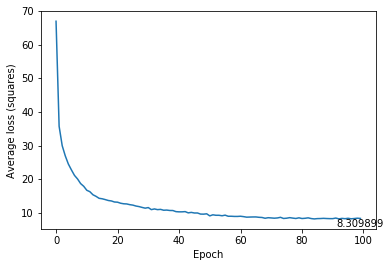

In [9]:
EPOCH = 100
model = Generator(DATA_NUM_WAYPOINTS,DATA_NUM_STEP)
start_time = '{0:%Y/%m/%d %H:%M:%S}'.format(datetime.datetime.now())
model, fig = train(model,X_train,epoch=EPOCH)
finish_time = '{0:%Y/%m/%d %H:%M:%S}'.format(datetime.datetime.now())
print('start:',start_time)
print('finish:',finish_time)

In [10]:
# log
def gen_filename():
    name_date = '{0:%Y%m%d%H%M}'.format(datetime.datetime.now())
    name_epoch = '{}ep'.format(EPOCH)
    name_datasize  = '{}data'.format(DATA_SIZE)
    name_num_step = '{}step'.format(DATA_NUM_STEP)
    name_space = '{}mm'.format(int(DATA_M_PER_STEP * 1000))
    fn = 'Cart' + name_space + name_num_step + '_' + name_date + '_'   + name_datasize + name_epoch
    return fn
dirname = gen_filename()
os.mkdir(dirname)
serializers.save_npz(dirname +'/'+ dirname+'.model', model)
fig.savefig(dirname + '/' + 'loss.png')

 --- input --- 
[[ 0.02992435  0.00184342 -1.44774633]
 [ 0.05939618  0.00734581 -1.32469633]
 [ 0.08796981  0.01642396 -1.20164633]
 [ 0.11521314  0.02894059 -1.07859633]
 [ 0.14071419  0.04470642 -0.95554633]
 [ 0.16408733  0.06348303 -0.83249633]
 [ 0.18497911  0.08498648 -0.70944633]
 [ 0.2030736   0.10889159 -0.58639633]
 [ 0.21809717  0.13483687 -0.46334633]
 [ 0.22982263  0.16242996 -0.34029633]]
 --- output --- 
[[[ 0.02870924  0.          0.15416917]
  [ 0.03051573  0.          0.16292772]
  [ 0.03010028  0.          0.16161472]
  [ 0.03025337  0.          0.23971248]
  [ 0.03225495  0.         -0.48384848]
  [ 0.03018563  0.          1.        ]
  [ 0.05006586  0.          1.        ]
  [ 0.0015783   0.         -0.9883676 ]
  [ 0.06654597  0.          0.9999444 ]
  [ 0.0210301   0.          0.9999428 ]]]
[[  8.833243   9.335071   9.259841  13.734513 -27.722477  57.29578
   57.29578  -56.629295  57.292595  57.292503]]
 --- error --- 
e_distance: variable(0.13999107)	e_dw: vari

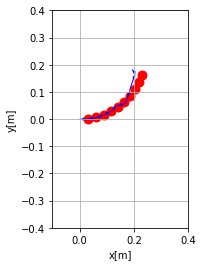

 --- grad --- 
variable([[[-385.204       54.1648   ]
           [-332.99356     53.94129  ]
           [-278.14932     49.478172 ]
           [-186.93094     41.365486 ]
           [ -18.290874    31.253887 ]
           [-141.92848     26.091064 ]
           [ 134.89523     11.798426 ]
           [ 232.691       11.640315 ]
           [  95.11502      1.7743528]
           [  92.9742      -1.       ]]])


In [11]:
rand_rad = xp.random.rand()*(2*DATA_RAD_PER_STEP)-DATA_RAD_PER_STEP # -36 ~ 36 m/step
x_test = data.generate_arc_path(DATA_NUM_WAYPOINTS,rand_rad,DATA_M_PER_STEP)
'''
x_test = xp.array(
    [[ 0.02293546, -0.04092823,0],
     [ 0.05309581, -0.05415406,0],
     [ 0.08393338, -0.06682136,0],
     [ 0.11579048, -0.07606434,0],
     [ 0.14647007, -0.08932315,0],
     [ 0.17848524, -0.09797464,0],
     [ 0.21082233, -0.10660645,0],
     [ 0.24306089, -0.11521195,0],
     [ 0.27361556, -0.12854306,0],
     [ 0.3055584,  -0.13706963,0]]
    , dtype = xp.float32)
'''
x = xp.ravel(x_test[:,0:2])
x = Variable(xp.array([x],dtype=xp.float32))
y = model(x)
# zero-padding
pad = Variable(xp.zeros((1,DATA_NUM_STEP,1),dtype=xp.float32))
y_pad = F.concat((y,pad),axis=2)
y_pad = F.permutate(y_pad, xp.array([0,2,1],'i'), axis=2)
print(' --- input --- ')
print(x_test)
print(' --- output --- ')
print(y_pad.data)
print(xp.rad2deg(y_pad.data[:,:,2]))
# loss
z_true = x_test
z = y_pad[0,0]
print(' --- error --- ')
Z = xp.array([([0,0,0]),(z.data)],dtype='float32')
for step in range(1,DATA_NUM_STEP):
    z = oplus(z,y_pad[0,step])
    Z = xp.vstack((Z,z.data))
loss = loss_function(y_pad, x_test, disp_loss=1)
print('loss:',loss)
print(' --- trajectory --- ')
print(Z)
print(z_true.shape)
fig = plot_path(Z,z_true,[-.1,.4],[-.4,.4])
print(' --- grad --- ')
loss.backward()
y_grad = chainer.grad( (loss,), (y,) )[0]
print(y_grad)

 --- input --- 
[[ 0.02971104  0.00359384 -1.33004633]
 [ 0.05770831  0.01416807 -1.08929633]
 [ 0.08237689  0.03111275 -0.84854633]
 [ 0.10229389  0.05345049 -0.60779633]
 [ 0.11631045  0.07989283 -0.36704633]
 [ 0.1236181   0.10891454 -0.12629633]
 [ 0.12379531  0.13884161  0.11445367]
 [ 0.11683186  0.16794783  0.35520367]
 [ 0.10312942  0.1945543   0.59595367]
 [ 0.08347835  0.21712634  0.83670367]]
 --- output --- 
[[[ 0.02916962  0.          0.3041773 ]
  [ 0.03005618  0.          0.32279626]
  [ 0.02983912  0.          0.32729575]
  [ 0.03032706  0.          0.3864121 ]
  [ 0.03203024  0.         -0.34012502]
  [ 0.02755854  0.          1.        ]
  [ 0.04880664  0.          1.        ]
  [ 0.02394123  0.         -0.9412835 ]
  [ 0.05587237  0.          0.9999875 ]
  [ 0.03941674  0.          0.9999869 ]]]
 --- error --- 
loss: variable(0.00363439)
loss: variable(0.00516783)
loss: variable(0.00461875)
loss: variable(0.00351962)
loss: variable(0.00979595)
loss: variable(0.003784

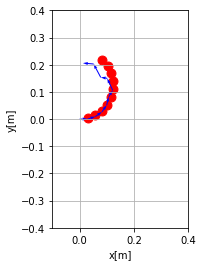

 --- input --- 
[[ 0.02881287  0.00720693 -1.08059633]
 [ 0.05083966  0.02713034 -0.59039633]
 [ 0.06089257  0.0550778  -0.10019633]
 [ 0.0566039   0.08446706  0.39000367]
 [ 0.03898373  0.10837629  0.88020367]
 [ 0.01218202  0.12117433  1.37040367]
 [-0.01748884  0.11984694  1.86060367]
 [-0.04304068  0.10470675  2.35080367]
 [-0.05845546  0.07931963  2.84100367]
 [-0.06010267  0.04966482  3.33120367]]
 --- output --- 
[[[0.03197616 0.         0.61840296]
  [0.02741071 0.         0.62831986]
  [0.02929869 0.         0.6465342 ]
  [0.03064255 0.         0.65446174]
  [0.03040478 0.         0.06332026]
  [0.02123958 0.         1.        ]
  [0.04879127 0.         1.        ]
  [0.03815087 0.         0.11705142]
  [0.03984359 0.         0.9999996 ]
  [0.03861232 0.         0.9999995 ]]]
 --- error --- 
loss: variable(0.00787059)
loss: variable(0.01176313)
loss: variable(0.01173934)
loss: variable(0.01204014)
loss: variable(0.02126929)
loss: variable(0.02076107)
loss: variable(0.04427512)

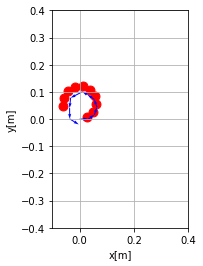

 --- input --- 
[[ 2.82383682e-02 -8.71844584e-03 -2.16971633e+00]
 [ 4.66466750e-02 -3.18388042e-02 -2.76863633e+00]
 [ 4.88168029e-02 -6.13126448e-02 -3.36755633e+00]
 [ 3.39933084e-02 -8.68798258e-02 -3.96647633e+00]
 [ 7.33639972e-03 -9.96401532e-02 -4.56539633e+00]
 [-2.18743838e-02 -9.51516280e-02 -5.16431633e+00]
 [-4.34704733e-02 -7.49767512e-02 -5.76323633e+00]
 [-4.99340518e-02 -4.61386014e-02 -6.36215633e+00]
 [-3.90150822e-02 -1.86760298e-02 -6.96107633e+00]
 [-1.45145682e-02 -2.14903520e-03 -7.55999633e+00]]
 --- output --- 
[[[ 0.02410319  0.         -0.6500423 ]
  [ 0.03376213  0.         -0.6349319 ]
  [ 0.03062714  0.         -0.65169704]
  [ 0.02754701  0.         -0.5793495 ]
  [ 0.03232989  0.         -0.8963471 ]
  [ 0.05303838  0.          1.        ]
  [ 0.00755352  0.          1.        ]
  [-0.02949994  0.         -0.9999849 ]
  [-0.00951351  0.          0.2594455 ]
  [-0.00832252  0.          0.27247396]]]
 --- error --- 
loss: variable(0.0096494)
loss: variab

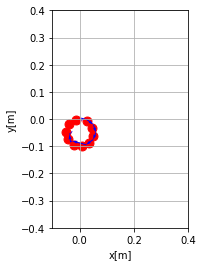

 --- input --- 
[[ 0.02833854  0.00847727 -0.98945633]
 [ 0.0473666   0.0311239  -0.40811633]
 [ 0.05083261  0.06049947  0.17322367]
 [ 0.03759782  0.08695277  0.75456367]
 [ 0.01201045  0.10179272  1.33590367]
 [-0.01752288  0.10014372  1.91724367]
 [-0.04129916  0.08254754  2.49858367]
 [-0.05150682  0.05478532  3.07992367]
 [-0.04479217  0.02597819  3.66126367]
 [-0.02336128  0.00559059  4.24260367]]
 --- output --- 
[[[0.02260199 0.         0.6638817 ]
  [0.03155849 0.         0.66148865]
  [0.03330324 0.         0.68150145]
  [0.0284205  0.         0.695112  ]
  [0.03905827 0.         0.15191342]
  [0.01641685 0.         1.        ]
  [0.06287739 0.         1.        ]
  [0.03690423 0.         0.30930322]
  [0.08397616 0.         0.9999999 ]
  [0.0480134  0.         0.9999998 ]]]
 --- error --- 
loss: variable(0.01023583)
loss: variable(0.01167859)
loss: variable(0.00993903)
loss: variable(0.01115801)
loss: variable(0.00855375)
loss: variable(0.01007219)
loss: variable(0.02844045)

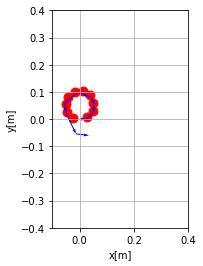

 --- input --- 
[[ 2.99860205e-02  7.93015182e-04 -1.51791633e+00]
 [ 5.98882108e-02  3.16984374e-03 -1.46503633e+00]
 [ 8.96229750e-02  7.12384091e-03 -1.41215633e+00]
 [ 1.19107185e-01  1.26439527e-02 -1.35927633e+00]
 [ 1.48258415e-01  1.97147469e-02 -1.30639633e+00]
 [ 1.76995166e-01  2.83164561e-02 -1.25351633e+00]
 [ 2.05237103e-01  3.84250330e-02 -1.20063633e+00]
 [ 2.32905269e-01  5.00122175e-02 -1.14775633e+00]
 [ 2.59922316e-01  6.30456161e-02 -1.09487633e+00]
 [ 2.86212713e-01  7.74887921e-02 -1.04199633e+00]]
 --- output --- 
[[[ 0.02828936  0.          0.06347918]
  [ 0.03077591  0.          0.06220083]
  [ 0.03038665  0.          0.05945985]
  [ 0.03001118  0.          0.14282109]
  [ 0.03241066  0.         -0.55788374]
  [ 0.03194518  0.          1.        ]
  [ 0.04962559  0.          1.        ]
  [-0.01546592  0.         -0.99535316]
  [ 0.07019905  0.          0.99984884]
  [ 0.00473573  0.          0.99984586]]]
 --- error --- 
loss: variable(0.00187284)
loss: varia

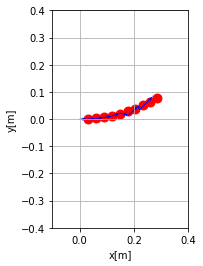

 --- input --- 
[[ 0.02965548  0.00392158 -1.30784633]
 [ 0.05727229  0.01541671 -1.04489633]
 [ 0.0809519   0.03369518 -0.78194633]
 [ 0.09906645  0.05750041 -0.51899633]
 [ 0.11037066  0.08519592 -0.25604633]
 [ 0.11408741  0.11487777  0.00690367]
 [ 0.1099612   0.14450547  0.26985367]
 [ 0.09827568  0.17204226  0.53280367]
 [ 0.07983418  0.19559512  0.79575367]
 [ 0.05590445  0.2135449   1.05870367]]
 --- output --- 
[[[ 0.02926057  0.          0.3314891 ]
  [ 0.02994281  0.          0.35138172]
  [ 0.02979693  0.          0.35727096]
  [ 0.03030692  0.          0.41174716]
  [ 0.03195921  0.         -0.31035823]
  [ 0.02714517  0.          1.        ]
  [ 0.04813142  0.          1.        ]
  [ 0.02774059  0.         -0.91920424]
  [ 0.05273984  0.          0.9999903 ]
  [ 0.04204431  0.          0.9999898 ]]]
 --- error --- 
loss: variable(0.00394141)
loss: variable(0.00567976)
loss: variable(0.00515444)
loss: variable(0.0041421)
loss: variable(0.01062326)
loss: variable(0.0048044

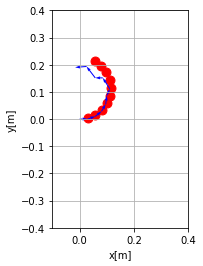

 --- input --- 
[[ 2.96820829e-02 -3.76830535e-03 -1.82335633e+00]
 [ 5.74808906e-02 -1.48341292e-02 -2.07591633e+00]
 [ 8.16326385e-02 -3.24953647e-02 -2.32847633e+00]
 [ 1.00604941e-01 -5.56314381e-02 -2.58103633e+00]
 [ 1.13194041e-01 -8.27744069e-02 -2.83359633e+00]
 [ 1.18601180e-01 -1.12202098e-01 -3.08615633e+00]
 [ 1.16483286e-01 -1.42047377e-01 -3.33871633e+00]
 [ 1.06974737e-01 -1.70416615e-01 -3.59127633e+00]
 [ 9.06788307e-02 -1.95509834e-01 -3.84383633e+00]
 [ 6.86295151e-02 -2.15734913e-01 -4.09639633e+00]]
 --- output --- 
[[[ 0.02938254  0.         -0.3442127 ]
  [ 0.02995273  0.         -0.36259612]
  [ 0.03002306  0.         -0.37142032]
  [ 0.02969632  0.         -0.29242316]
  [ 0.03043164  0.         -0.79295015]
  [ 0.04282651  0.          1.        ]
  [ 0.03491377  0.          1.        ]
  [-0.06642689  0.         -0.99987036]
  [ 0.0488493   0.          0.98203987]
  [-0.0484677   0.          0.9820875 ]]]
 --- error --- 
loss: variable(0.00378019)
loss: varia

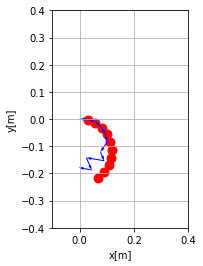

 --- input --- 
[[ 2.99446744e-02 -1.57684439e-03 -1.67601633e+00]
 [ 5.95581296e-02 -6.28993603e-03 -1.78123633e+00]
 [ 8.85128101e-02 -1.40871432e-02 -1.88645633e+00]
 [ 1.16488447e-01 -2.48822208e-02 -1.99167633e+00]
 [ 1.43175601e-01 -3.85557639e-02 -2.09689633e+00]
 [ 1.68279084e-01 -5.49565291e-02 -2.20211633e+00]
 [ 1.91521226e-01 -7.39031068e-02 -2.30733633e+00]
 [ 2.12644944e-01 -9.51859283e-02 -2.41255633e+00]
 [ 2.31416589e-01 -1.18569583e-01 -2.51777633e+00]
 [ 2.47628526e-01 -1.43795425e-01 -2.62299633e+00]]
 --- output --- 
[[[ 0.02712406  0.         -0.1253216 ]
  [ 0.03135979  0.         -0.14380997]
  [ 0.0310219   0.         -0.14657344]
  [ 0.02915114  0.         -0.06536097]
  [ 0.03266503  0.         -0.6822816 ]
  [ 0.03637353  0.          1.        ]
  [ 0.0437432   0.          1.        ]
  [-0.04628162  0.         -0.9990956 ]
  [ 0.06458287  0.          0.9985211 ]
  [-0.02761864  0.          0.9985161 ]]]
 --- error --- 
loss: variable(0.00323146)
loss: varia

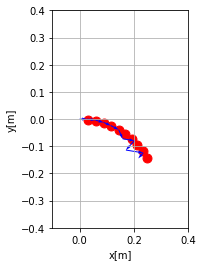

 --- input --- 
[[ 0.0297144   0.00357299 -1.33145633]
 [ 0.05773476  0.01408828 -1.09211633]
 [ 0.08246363  0.03094637 -0.85277633]
 [ 0.10249118  0.05318618 -0.61343633]
 [ 0.11667564  0.0795398  -0.37409633]
 [ 0.12420834  0.10850478 -0.13475633]
 [ 0.12465983  0.13842982  0.10458367]
 [ 0.11800438  0.16760887  0.34392367]
 [ 0.10462141  0.19437841  0.58326367]
 [ 0.08527391  0.21721229  0.82260367]]
 --- output --- 
[[[ 0.02916332  0.          0.3022646 ]
  [ 0.03006384  0.          0.3208427 ]
  [ 0.02984088  0.          0.3252441 ]
  [ 0.03032781  0.          0.38466832]
  [ 0.03203382  0.         -0.34211555]
  [ 0.02759135  0.          1.        ]
  [ 0.04882641  0.          1.        ]
  [ 0.0237432   0.         -0.9424833 ]
  [ 0.05601244  0.          0.99998724]
  [ 0.03928992  0.          0.99998665]]]
 --- error --- 
loss: variable(0.00361524)
loss: variable(0.00514042)
loss: variable(0.00459753)
loss: variable(0.00348148)
loss: variable(0.0097051)
loss: variable(0.0037322

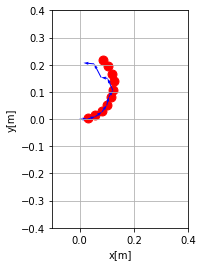

 --- input --- 
[[ 2.97500383e-02 -3.34404858e-03 -1.79466633e+00]
 [ 5.80152876e-02 -1.32092968e-02 -2.01853633e+00]
 [ 8.33850629e-02 -2.91033819e-02 -2.24240633e+00]
 [ 1.04593189e-01 -5.02330490e-02 -2.46627633e+00]
 [ 1.20581193e-01 -7.55437415e-02 -2.69014633e+00]
 [ 1.30551134e-01 -1.03772233e-01 -2.91401633e+00]
 [ 1.34005423e-01 -1.33509673e-01 -3.13788633e+00]
 [ 1.30771660e-01 -1.63271901e-01 -3.36175633e+00]
 [ 1.21011240e-01 -1.91573520e-01 -3.58562633e+00]
 [ 1.05211292e-01 -2.17002029e-01 -3.80949633e+00]]
 --- output --- 
[[[ 0.02879675  0.         -0.30052817]
  [ 0.03031036  0.         -0.32043988]
  [ 0.03030511  0.         -0.3279119 ]
  [ 0.02953539  0.         -0.24803166]
  [ 0.03099124  0.         -0.773404  ]
  [ 0.04140281  0.          1.        ]
  [ 0.03711294  0.          1.        ]
  [-0.06378793  0.         -0.9998097 ]
  [ 0.05330488  0.          0.98923326]
  [-0.04566005  0.          0.98925614]]]
 --- error --- 
loss: variable(0.00347727)
loss: varia

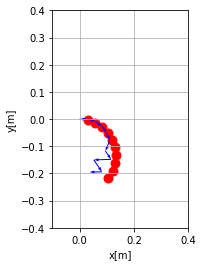

In [12]:
for i in range(10):
    rand_rad = xp.random.rand()*(2*DATA_RAD_PER_STEP)-DATA_RAD_PER_STEP # -36 ~ 36 m/step
    x_test = data.generate_arc_path(DATA_NUM_WAYPOINTS,rand_rad,DATA_M_PER_STEP)
    x = xp.ravel(x_test[:,0:2])
    x = Variable(xp.array([x],dtype=xp.float32))
    y = model(x)
    # zero-padding
    pad = Variable(xp.zeros((1,DATA_NUM_STEP,1),dtype=xp.float32))
    y_pad = F.concat((y,pad),axis=2)
    y_pad = F.permutate(y_pad, xp.array([0,2,1],'i'), axis=2)
    print(' --- input --- ')
    print(x_test)
    print(' --- output --- ')
    print(y_pad.data)
    # loss
    z_true = x_test
    z = y_pad[0,0]
    e = error_squares(z,z_true[0])
    print(' --- error --- ')
    print('loss:',e)
    Z = xp.array([([0,0,0]),(z.data)],dtype='float32')
    for step in range(1,DATA_NUM_STEP):
        z = oplus(z,y_pad[0,step])
        e = error_squares(z,z_true[step])
        print('loss:',e)
        Z = xp.vstack((Z,z.data))
    print(' --- trajectory --- ')
    print(Z)
    print(z_true.shape)
    fig = plot_path(Z,z_true,[-.1,.4],[-.4,.4])
    fig.savefig(dirname + '/test' + str(i) + '.png')